In [8]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import dataset
from bs4 import BeautifulSoup 
import requests
from urllib.parse import unquote
from urllib.parse import urljoin

In [2]:
#Initiating the session
scrape = requests.Session()
#Getting the first URL
entry = 'https://www.amazon.in/'

In [3]:
                                e = scrape.get(entry)
soup_main = BeautifulSoup(e.text,'html.parser')

In [4]:
#get the links
main_link = soup_main.find_all('a',class_='nav-a')

In [5]:
links=[]
for main in main_link:
    links.append(main.get('href'))

In [6]:
#select those links that start with '/'
collected = []
for link in links[3:]:
    temp = urljoin(entry,link)
    collected.append(temp)
        
print('There are total {} links collected from amazon main page'.format(len(collected)))

There are total 32 links collected from amazon main page


In [7]:
#There is a pattern to the links. End of every link is having the clue to where the link is heading.
main_dict = {}
for links in collected:
    temp = links.split('=')
    #split the link, take the heading
    main_dict[temp[-1]] = links

In [8]:
main_dict.keys()

dict_keys(['nav_orders_first', 'nav_cart', 'nav_cs_bestsellers', 'nav_cs_mobiles', 'nav_cs_gb', 'nav_cs_help', 'nav_cs_electronics', 'nav_cs_books', 'nav_cs_primelink_nonmember', 'nav_cs_fashion', 'nav_cs_newreleases', 'nav_cs_home', 'nav_cs_apay', 'nav_cs_pc', 'nav_cs_coupons', 'nav_cs_toys', 'nav_cs_sell', 'nav_cs_gc', 'nav_cs_automotive', 'nav_cs_video_games', 'nav_cs_grocery', 'nav_cs_beauty', 'nav_cs_sports', 'nav_cs_hpc', 'nav_cs_baby', 'nav_cs_pets', 'nav_cs_kindle_books', 'nav_cs_hi', 'nav_cs_giftfinder', 'nav_cs_amazonbasics', 'nav_cs_audible', 'nav_cs_sns'])

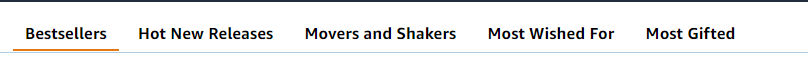

In [9]:
#There are couple of links that lead to personal areas, that require sign-in. Poping them from the dict
main_dict.pop('nav_orders_first')
main_dict.pop('nav_cart')
main_dict.pop('nav_cs_primelink_nonmember')
main_dict.pop('nav_cs_help')
main_dict.pop('nav_cs_sns')
main_dict.pop('nav_cs_apay')

'https://www.amazon.in/gp/sva/dashboard?ref_=nav_cs_apay'

In [10]:
link_collector = pd.DataFrame(list(main_dict.items()),columns=['topics','links'])

In [11]:
my_headers = {
'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 ' + ' (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36',
'referer':'http://localhost:8888/'    
}

In [12]:
link_collector.links[0]

'https://www.amazon.in/gp/bestsellers/?ref_=nav_cs_bestsellers'

In [13]:
link_collector_dict = {} #dict to hold the list of links collected from each links


for index, crawl in enumerate(link_collector.links):
    link_hrf = []
    print(index,crawl)
    lev = scrape.get(crawl,headers=my_headers)
    lev_soup = BeautifulSoup(lev.text,'html.parser')
    for hrf in lev_soup.find_all('a', attrs={'class':'a-link-normal'}):     
        temp = hrf.get('href')
        link_hrf.append(temp)

    link_collector_dict[link_collector.topics[index]] = link_hrf

0 https://www.amazon.in/gp/bestsellers/?ref_=nav_cs_bestsellers
1 https://www.amazon.in/mobile-phones/b/?ie=UTF8&node=1389401031&ref_=nav_cs_mobiles
2 https://www.amazon.in/deals?ref_=nav_cs_gb
3 https://www.amazon.in/electronics/b/?ie=UTF8&node=976419031&ref_=nav_cs_electronics
4 https://www.amazon.in/Books/b/?ie=UTF8&node=976389031&ref_=nav_cs_books
5 https://www.amazon.in/gp/browse.html?node=6648217031&ref_=nav_cs_fashion
6 https://www.amazon.in/gp/new-releases/?ref_=nav_cs_newreleases
7 https://www.amazon.in/Home-Kitchen/b/?ie=UTF8&node=976442031&ref_=nav_cs_home
8 https://www.amazon.in/computers-and-accessories/b/?ie=UTF8&node=976392031&ref_=nav_cs_pc
9 https://www.amazon.in/amazon-coupons/b/?_encoding=UTF8&node=10465704031&ref_=nav_cs_coupons
10 https://www.amazon.in/Toys-Games/b/?ie=UTF8&node=1350380031&ref_=nav_cs_toys
11 https://www.amazon.in/b/?node=2838698031&ld=AZINSOANavDesktop&ref_=nav_cs_sell
12 https://www.amazon.in/gift-card-store/b/?ie=UTF8&node=3704982031&ref_=nav_cs

In [14]:
link_list_df = pd.DataFrame(list(link_collector_dict.items()),columns=['topics','links_list'])
link_list_df['link_len'] = link_list_df.links_list.apply(lambda x: len(x))
link_list_df = link_list_df[link_list_df.link_len > 60]

In [15]:
link_list_df

,topics,links_list,link_len
0,nav_cs_bestsellers,"[/gp/bestsellers/luggage, /WILDHORN%C2%AE-Cart...",149
6,nav_cs_newreleases,"[/gp/new-releases/luggage, /QURATRIX-Silver-Ou...",146


Out of 28 links only 3 pages loaded with default referer and settings. Rest of page needs more info. 
I am planning to go ahead scrape the links under bestsellers first

1) Start by making the list of links under best sellers as full links and see if they provide the content

2) If it provides the content, then check the tags, class, id that can be used to get the data.

3) Create the dataframe and store the data directly in the dataframe.

learn more about the usage

driver.execute_script("window.scrollBy(0, document.body.scrollHeight-400)")

In [2]:
from selenium import webdriver
import time as time
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import ElementNotInteractableException

In [3]:
def get_pagelevel_data(beauty_soup, df):
    trial_L1 = beauty_soup.find_all('div',attrs={'id':'gridItemRoot'})
    start = len(df)
    for index,trial in enumerate(trial_L1):
        df.loc[start+index,'Name'] = trial.select('span')[1].get_text()
        df.loc[start+index,'reviews'] = trial.select('span')[3].get_text()
        df.loc[start+index,'stars'] = trial.select('span')[2].get_text()
        df.loc[start+index,'price'] = trial.select('span')[4].get_text()
        df.loc[start+index,'link_in'] = trial.find('a',attrs={'class':'a-link-normal'}).get('href')
    end = len(df)
    print('Total data got is {}'.format(end-start))

In [4]:
#Creating a subroutine to get page
def get_page(main_driver):
    element = main_driver.find_element_by_class_name('a-last')
    main_driver.execute_script("arguments[0].scrollIntoView();",element)
    time.sleep(5)
    soup = main_driver.page_source
    trial = BeautifulSoup(soup,'html.parser')
    return trial

In [5]:
#get the pages that are still un-selected. These many clicks will be required to traverse the site
def get_page_avbl(page_soup):
    return len(page_soup.find_all('li',attrs={'class':'a-normal'}))

In [6]:
def crawler(page_url):
    driver = webdriver.Chrome()
    driver.get(page_url)
    driver.maximize_window()
    stor_dataframe = pd.DataFrame()
    #Above code initialises the selenium driver and opens the browser
    
    firstpage = get_page(driver) #gets the first page
    get_pagelevel_data(firstpage,stor_dataframe) # gets the data in the first page
    page_avbl = get_page_avbl(firstpage) #gets the number of pages
    print('This url contains {} pages'.format(page_avbl+1))
    for page in range(page_avbl):#looping the pages available
        print('Moving to {} page for scraping'.format(page+2))
        try:
            driver.find_element_by_class_name('a-last').click() #moving to the next page
            page_next = get_page(driver) #getting next page data
            get_pagelevel_data(page_next,stor_dataframe) # collecting the next page data
        except NoSuchElementException as nse:
            print('Element not found, breaking')
    print('ending crawler for {} and returning payload'.format(page_url))
    print('Links collected is {} and quitting driver'.format(stor_dataframe.shape[0]))
    driver.quit()
    return stor_dataframe #returning the dataframe

In [1]:
vid_url = 'https://www.amazon.in/gp/bestsellers/videogames'

In [14]:
driver = webdriver.Chrome()
driver.get(vid_url)
driver.maximize_window()

In [15]:
firstpage = get_page(driver)

C:\WorkFiles\WPy64-37120\pypy3.7-v7.3.7-win64\site-packages\ipykernel_launcher.py:3: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
data = firstpage.find_all('li',attrs={'role':'gridcell'})

In [44]:
data[1].select('span')[0].select('span')

[<span class="a-size-small aok-float-left zg-badge-body zg-badge-color"><span class="zg-badge-text">#2</span></span>,
 <span class="zg-badge-text">#2</span>,
 <span class="aok-float-left zg-badge-triangle zg-badge-color"></span>,
 <span class="aok-inline-block zg-item"><a class="a-link-normal" href="/Sony-PlayStation-Network-Delivery-Digital/dp/B07K6PVXJZ/ref=zg_bs_videogames_2/259-2952639-3601935?_encoding=UTF8&amp;psc=1&amp;refRID=H99TBA73694K1VH7EZGB"><span class="zg-text-center-align"><div class="a-section a-spacing-small"><img alt="Rs.500 Sony PlayStation Network Wallet Top-Up (Email Delivery in 1 hour- Digital Voucher Code)" height="200" src="https://images-eu.ssl-images-amazon.com/images/I/410erw8EwMS._AC_UL200_SR200,200_.jpg" width="200"/></div></span>
 <div aria-hidden="true" class="p13n-sc-truncated" data-rows="1" title="Rs.500 Sony PlayStation Network Wallet Top-Up (Email Delivery in 1 hour- Digital Voucher Code)">Rs.500 Sony PlayStation Network Wallet Top…</div>
 </a><div c

In [34]:
df = pd.DataFrame()
start = len(df)
for index,trial in enumerate(data):
    df.loc[start+index,'Name'] = trial.select('span')[1].get_text()
    df.loc[start+index,'reviews'] = trial.select('span')[3].get_text()
    df.loc[start+index,'stars'] = trial.select('span')[2].get_text()
    df.loc[start+index,'price'] = trial.select('span')[4].get_text()
    df.loc[start+index,'link_in'] = trial.find('a',attrs={'class':'a-link-normal'}).get('href')
end = len(df)

In [35]:
df

,Name,reviews,stars,price,link_in
0,#1,,#1,"\nAmazonBasics Extended Gaming Mouse Pad,Black...",/AmazonBasics-Extended-Gaming-Mouse-Black/dp/B...
1,#2,,#2,\nRs.500 Sony PlayStation Network Wallet Top…\...,/Sony-PlayStation-Network-Delivery-Digital/dp/...
2,#3,,#3,\nRs.1000 Sony PlayStation Network Wallet Top…...,/Rs-1000-Sony-PlayStation-Network-Delivery/dp/...
3,#4,,#4,\nINR 250 Steam Wallet Code (Digital Code…\nVa...,/Steam-Wallet-Digital-Delivery-within/dp/B0874...
4,#5,,#5,"\nJBL Quantum 100, Wired Over Ear Gaming Headp...",/JBL-Quantum-Over-Ear-Headset-Detachable/dp/B0...
5,#6,,#6,\nCosmic Byte GS410 Wired Over-ear…\nCosmic By...,/Cosmic-Byte-Headphones-Laptop-Android/dp/B074...
6,#7,,#7,\nRs.2000 Sony PlayStation Network Wallet Top…...,/Rs-2000-Sony-PlayStation-Network-Delivery/dp/...
7,#8,,#8,\nRs.1500 Sony PlayStation Network Wallet Top…...,/Rs-1500-Sony-PlayStation-Network-Delivery/dp/...
8,#9,,#9,\nFIFA 22 (PS4)\nElectronic Arts\n\n\n4.6 out ...,/Electronic-Arts-FIFA-22-PS4/dp/B0999ZP8G6/ref...
9,#10,,#10,\nXbox One Series S\nXbox\n\n\n4.8 out of 5 st...,/Xbox-Series-S/dp/B08J89D6BW/ref=zg_bs_videoga...


In [17]:
stor_dataframe = pd.DataFrame()
get_pagelevel_data(firstpage,stor_dataframe)

Total data got is 0


In [13]:
vid_games = crawler(vid_url)

C:\WorkFiles\WPy64-37120\pypy3.7-v7.3.7-win64\site-packages\ipykernel_launcher.py:3: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  This is separate from the ipykernel package so we can avoid doing imports until


Total data got is 0
This url contains 2 pages
Moving to 2 page for scraping


C:\WorkFiles\WPy64-37120\pypy3.7-v7.3.7-win64\site-packages\ipykernel_launcher.py:15: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  from ipykernel import kernelapp as app


Total data got is 0
ending crawler for https://www.amazon.in/gp/bestsellers/videogames and returning payload
Links collected is 0 and quitting driver


In [10]:
vid_games.head()

""


Next step is to join the URLs and get the product level details. 

Join the link of each product, by creating the function for that purpose and send the created dataframe

scrape the product page of the information

store it back in the initial dataframe itself

In [11]:
#creating full_linkins for products
def f_link_create(df):
    for index,links in enumerate(df.link_in):
        #print(links)
        df.loc[index,'f_link'] = urljoin('https://www.amazon.in/',links)

    return df

In [12]:
vid_games = f_link_create(vid_games)

AttributeError: 'DataFrame' object has no attribute 'link_in'

In [192]:
def crawler_product(page_url,df,indexF):
    driver = webdriver.Chrome()
    driver.get(page_url)
    driver.maximize_window()
    prod_soup = driver.page_source
    prod_nugs = BeautifulSoup(prod_soup,'html.parser')
   
    #Populating the dataframe directly with the below commands. The details were found using 
    table_prod_1 = prod_nugs.find('table',attrs={'id':'productDetails_techSpec_section_1'})
    table_prod_2 = prod_nugs.find('table',attrs={'id':'productDetails_detailBullets_sections1'})
    review_table = prod_nugs.find_all('table',attrs={'id':'histogramTable'})[1]
    if table_prod_1 == None or table_prod_2 == None :
        review_table = prod_nugs.find_all('table',attrs={'id':'histogramTable'})[1]
            #Scraping of the data from the tables
        df.loc[indexF,'brand'] = 'voucher_or_program'
        df.loc[indexF,'color'] = 'voucher_or_program'
        df.loc[indexF,'Pdt_dimension'] = 'voucher_or_program'
        df.loc[indexF,'Weight'] = 'voucher_or_program'
        df.loc[indexF,'origin'] = 'voucher_or_program'
        df.loc[indexF,'ASIN'] = 'voucher_or_program'
        df.loc[indexF,'category'] = 'voucher_or_program'
        df.loc[indexF,'5Star'] = review_table.find_all('tr')[0].find_all('span',attrs={'class':'a-size-base'})[1].get_text().strip()
        df.loc[indexF,'4Star'] = review_table.find_all('tr')[1].find_all('span',attrs={'class':'a-size-base'})[1].get_text().strip()
        df.loc[indexF,'3Star'] = review_table.find_all('tr')[2].find_all('span',attrs={'class':'a-size-base'})[1].get_text().strip()
        df.loc[indexF,'2Star'] = review_table.find_all('tr')[3].find_all('span',attrs={'class':'a-size-base'})[1].get_text().strip()
        df.loc[indexF,'1Star'] = review_table.find_all('tr')[4].find_all('span',attrs={'class':'a-size-base'})[1].get_text().strip()
    else:
        #Scraping of the data from the tables
        df.loc[indexF,'brand'] = table_prod_1.find_all('td')[0].get_text().strip()
        df.loc[indexF,'color'] = table_prod_1.find_all('td')[2].get_text().strip()
        df.loc[indexF,'Pdt_dimension'] = table_prod_2.find_all('td')[-2].get_text().strip()
        df.loc[indexF,'Weight'] = table_prod_2.find_all('td')[-1].get_text().strip()
        df.loc[indexF,'origin'] = table_prod_1.find_all('td')[-1].get_text().strip()
        df.loc[indexF,'ASIN'] = table_prod_2.find_all('td')[0].get_text().strip()
        df.loc[indexF,'category'] = table_prod_2.find_all('td')[-1].get_text().strip()
        df.loc[indexF,'5Star'] = review_table.find_all('tr')[0].find_all('span',attrs={'class':'a-size-base'})[1].get_text().strip()
        df.loc[indexF,'4Star'] = review_table.find_all('tr')[1].find_all('span',attrs={'class':'a-size-base'})[1].get_text().strip()
        df.loc[indexF,'3Star'] = review_table.find_all('tr')[2].find_all('span',attrs={'class':'a-size-base'})[1].get_text().strip()
        df.loc[indexF,'2Star'] = review_table.find_all('tr')[3].find_all('span',attrs={'class':'a-size-base'})[1].get_text().strip()
        df.loc[indexF,'1Star'] = review_table.find_all('tr')[4].find_all('span',attrs={'class':'a-size-base'})[1].get_text().strip()
    
    print('Completed the data collection')
    driver.quit()

In [200]:
for indexF,prod_link in enumerate(vid_games.f_link[94:]):
    crawler_product(prod_link,vid_games,indexF)

Completed the data collection
Completed the data collection
Completed the data collection
Completed the data collection
Completed the data collection
Completed the data collection


In [187]:
review_table.find_all('tr')[0].find_all('span',attrs={'class':'a-size-base'})[1].get_text().strip()

'66%'

In [201]:
vid_games[vid_games.brand.isna()]

,Name,reviews,stars,price,link_in,f_link,brand,color,Pdt_dimension,Weight,origin,ASIN,category,5Star,4Star,3Star,2Star,1Star
94,Sony Horizon: Zero Dawn - Complete Edition (Pl...,4.5 out of 5 stars,Sony,"1,528",/Horizon-Zero-Dawn-Complete-PS4/dp/B07D2NY7RW/...,https://www.amazon.in/Horizon-Zero-Dawn-Comple...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,Cosmic Byte GS410 Headphones with Mic and for ...,4.1 out of 5 stars,Cosmic Byte,"18,705",/Cosmic-Byte-GS410-Headphones-Grey/dp/B07K7XRJ...,https://www.amazon.in/Cosmic-Byte-GS410-Headph...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,Microsoft Xbox Series X/S Wireless Controller ...,4.3 out of 5 stars,Microsoft,255,/Microsoft-Wireless-Controller-USB-C-Cable/dp/...,https://www.amazon.in/Microsoft-Wireless-Contr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,Nitho Switch Armour Case Lite for Nintendo Swi...,4.5 out of 5 stars,Nitho,19,/Nitho-NITHO-NSW-ACLT-K-Switch-Armour-Case/dp/...,https://www.amazon.in/Nitho-NITHO-NSW-ACLT-K-S...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,"Blue Yeti USB Microphone for Recording, Stream...","15,241",4.3 out of 5 stars,"₹10,995.00",/Blue-Yeti-USB-Microphone-Midnight/dp/B01LY6Z2...,https://www.amazon.in/Blue-Yeti-USB-Microphone...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,Marvel's Spider Man (PS4),4.6 out of 5 stars,Sony,"2,837",/Sony-195229-Marvels-Spider-Man/dp/B07CR4GQD3/...,https://www.amazon.in/Sony-195229-Marvels-Spid...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
vid_games[vid_games.f_link == 'https://www.amazon.in/Call-Duty-Infinite-Warfare-PS4/dp/B01JG2VZFQ/ref=zg_bs_videogames_58/260-6571345-4071009?pd_rd_i=B01JG2VZFQ&psc=1']

,Name,reviews,stars,price,link_in,f_link,brand,color,Pdt_dimension,Weight,origin,ASIN,category,5Star,4Star,3Star,2Star,1Star
57,Call of Duty: Infinite Warfare (PS4),4.2 out of 5 stars,ACTIVISION,"1,876",/Call-Duty-Infinite-Warfare-PS4/dp/B01JG2VZFQ/...,https://www.amazon.in/Call-Duty-Infinite-Warfa...,diff_product,diff_product,diff_product,diff_product,diff_product,diff_product,diff_product,57%,21%,10%,5%,7%


In [45]:
driver.quit()

In [65]:
len(prod_nugs.find_all('span'))

1203

In [66]:
len(prod_nugs.find_all('li'))

118

In [67]:
len(prod_nugs.find_all('a'))

479

In [ ]:
for d in soup.findAll('div', attrs={'class':'a-section a-spacing-none aok-relative'}):
        #print(d)
        name = d.find('span', attrs={'class':'zg-text-center-align'})
        n = name.find_all('img', alt=True)
        #print(n[0]['alt'])
        author = d.find('a', attrs={'class':'a-size-small a-link-child'})
        rating = d.find('span', attrs={'class':'a-icon-alt'})
        users_rated = d.find('a', attrs={'class':'a-size-small a-link-normal'})
        price = d.find('span', attrs={'class':'p13n-sc-price'})

        all1=[]

        if name is not None:
            #print(n[0]['alt'])
            all1.append(n[0]['alt'])
        else:
            all1.append("unknown-product")

        if author is not None:
            #print(author.text)
            all1.append(author.text)
        elif author is None:
            author = d.find('span', attrs={'class':'a-size-small a-color-base'})
            if author is not None:
                all1.append(author.text)
            else:    
                all1.append('0')

        if rating is not None:
            #print(rating.text)
            all1.append(rating.text)
        else:
            all1.append('-1')

        if users_rated is not None:
            #print(price.text)
            all1.append(users_rated.text)
        else:
            all1.append('0')     

        if price is not None:
            #print(price.text)
            all1.append(price.text)
        else:
            all1.append('0')
        alls.append(all1)    
    return alls

In [1]:
# product title
title = soup.find(id='productTitle').get_text().strip()

# to prevent script from crashing when there isn't a price for the product
try:
    price = float(soup.find(id='priceblock_ourprice').get_text().replace('.', '').replace('€', '').replace(',', '.').strip())
except:
    price = ''

# review score
review_score = float(soup.select('.a-star-4-5')[0].get_text().split(' ')[0].replace(",", "."))

# how many reviews
review_count = int(soup.select('#acrCustomerReviewText')[0].get_text().split(' ')[0].replace(".", ""))

# checking if there is "Out of stock" and if not, it means the product is available
try:
    soup.select('#availability .a-color-state')[0].get_text().strip()
    stock = 'Out of Stock'
except:
    stock = 'Available'

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14072 sha256=2a275861992e29f4028c01341d2884cb884a0b21f14d421949b26b9db89f9420
  Stored in directory: c:\users\d30001e013\appdata\local\pip\cache\wheels\3c\87\5e\394d2e92270af924b348066ce11abbf82ee997868b83fade1b
Successfully built pytesseract


You should consider upgrading via the 'C:\WorkFiles\WPy64-37120\pypy3.7-v7.3.7-win64\python.exe -m pip install --upgrade pip' command.


In [ ]:
try:
		title = soup.find("span",
						attrs={"id": 'productTitle'})
	title_value = title.string

		title_string = title_value
					.strip().replace(',', '')
		
except AttributeError:

		title_string = "NA"

		print("product Title = ", title_string)
